# Currency Predictor

In [30]:
# library import
import requests
import datetime
from io import StringIO

from prophet import Prophet
from prophet.plot import plot_plotly

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

## 1. Data exploration

### Configure currencies and dates to apply prediction

In [9]:
# Enter start & end dates
start_date = datetime.date(2022, 6, 1)
end_date = datetime.date(2022, 12, 1)

# Enter source & target currencies
source_currency = "USD"
target_currency = "INR"

### Gather FX rate data for above params from API and pre-process it

In [10]:
# functions for getting fx data from api
API_URL = "https://marketdata.tradermade.com/api/v1"

def get_api_key():
    return open("api.key", mode='r').read()


def send_api_request(url):
    headers = {'Accept': 'application/json'}
    return requests.get(url=url, headers=headers)


def get_fx_data(source_currency, target_currency, start_date, end_date):
    api_key = get_api_key()
    url = f"{API_URL}/timeseries?currency={source_currency}{target_currency}&api_key={api_key}&start_date={start_date}&end_date={end_date}&format=csv"
    return send_api_request(url).text
 

def get_currency_df(source_currency, target_currency, start_date, end_date):
    currency_rates = get_fx_data(source_currency, target_currency, start_date, end_date)
    return pd.read_csv(StringIO(currency_rates), sep=",")


currency_df = get_currency_df(source_currency, target_currency, start_date, end_date)
currency_df.head()

,date,open,high,low,close
0,2022-06-01,77.63204,77.95052,77.421,77.57663
1,2022-06-02,77.57663,77.87871,77.360,77.38761
2,2022-06-03,77.38761,77.74010,77.370,77.70285
3,2022-06-06,77.62303,77.90107,77.537,77.84755
4,2022-06-07,77.84753,78.06863,77.608,77.67934


### Explore data, pattern for the provided exchange rate & dates

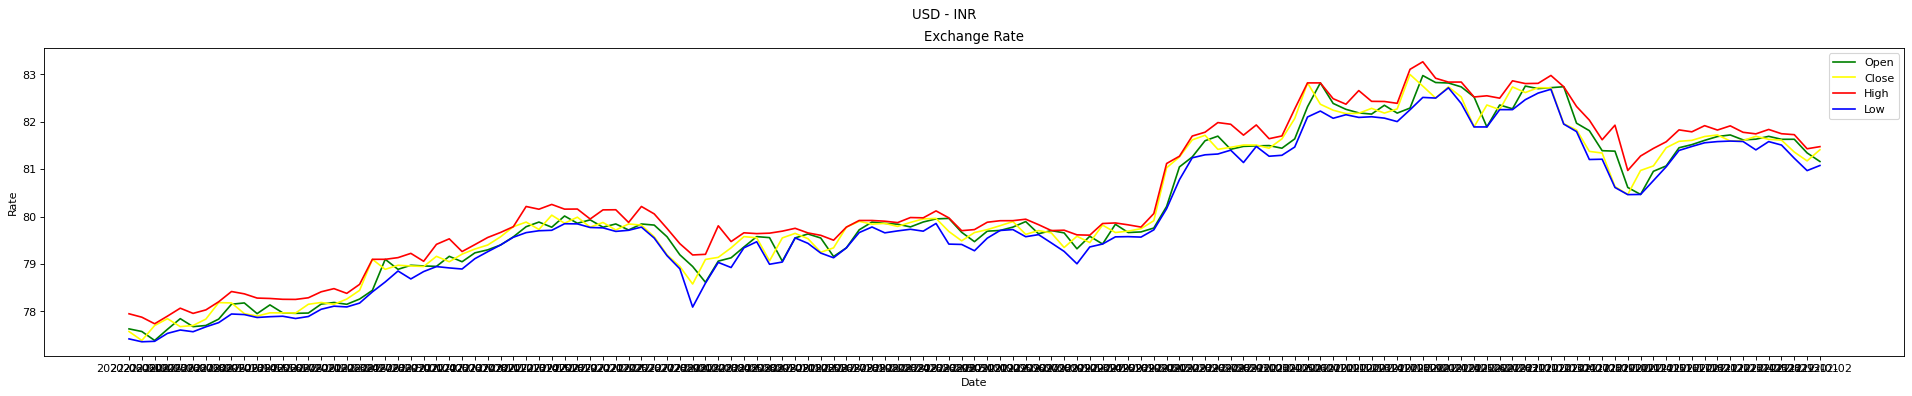

           open      high       low     close
open   1.000000  0.992448  0.993560  0.984996
high   0.992448  1.000000  0.991536  0.991625
low    0.993560  0.991536  1.000000  0.993169
close  0.984996  0.991625  0.993169  1.000000


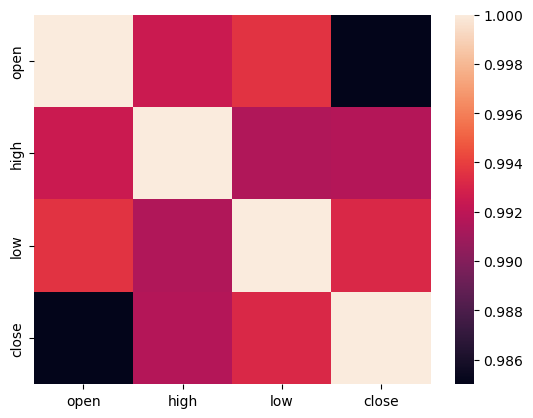

In [11]:
plt.figure(figsize=(30,5), dpi=80)
plt.suptitle(f"{source_currency} - {target_currency}")
plt.title(f"Exchange Rate")
plt.plot(currency_df['date'], currency_df['open'], color='green', label='Open')
plt.plot(currency_df['date'], currency_df['close'], color='yellow', label='Close')
plt.plot(currency_df['date'], currency_df['high'], color='red', label='High')
plt.plot(currency_df['date'], currency_df['low'], color='blue', label='Low')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

print(currency_df.corr())
sns.heatmap(currency_df.corr())
plt.show()

In [12]:
x = currency_df[["open", "high", "low"]].to_numpy()
y = currency_df["close"].to_numpy().reshape(-1, 1)

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

## Data Analysis

### Applying Decision Tree Regressor model

In [14]:
dtr_model = DecisionTreeRegressor()
dtr_model.fit(xtrain, ytrain)
dtr_y_pred = dtr_model.predict(xtest)

pred_data_decision_tree = pd.DataFrame(data={"Predicted Rate": dtr_y_pred.flatten()})
print("Score of the Decision Tree Regressor Model: ", dtr_model.score(xtest, ytest)*100)

Score of the Decision Tree Regressor Model:  96.02741893287119


#### Plotting prediction results with actual results

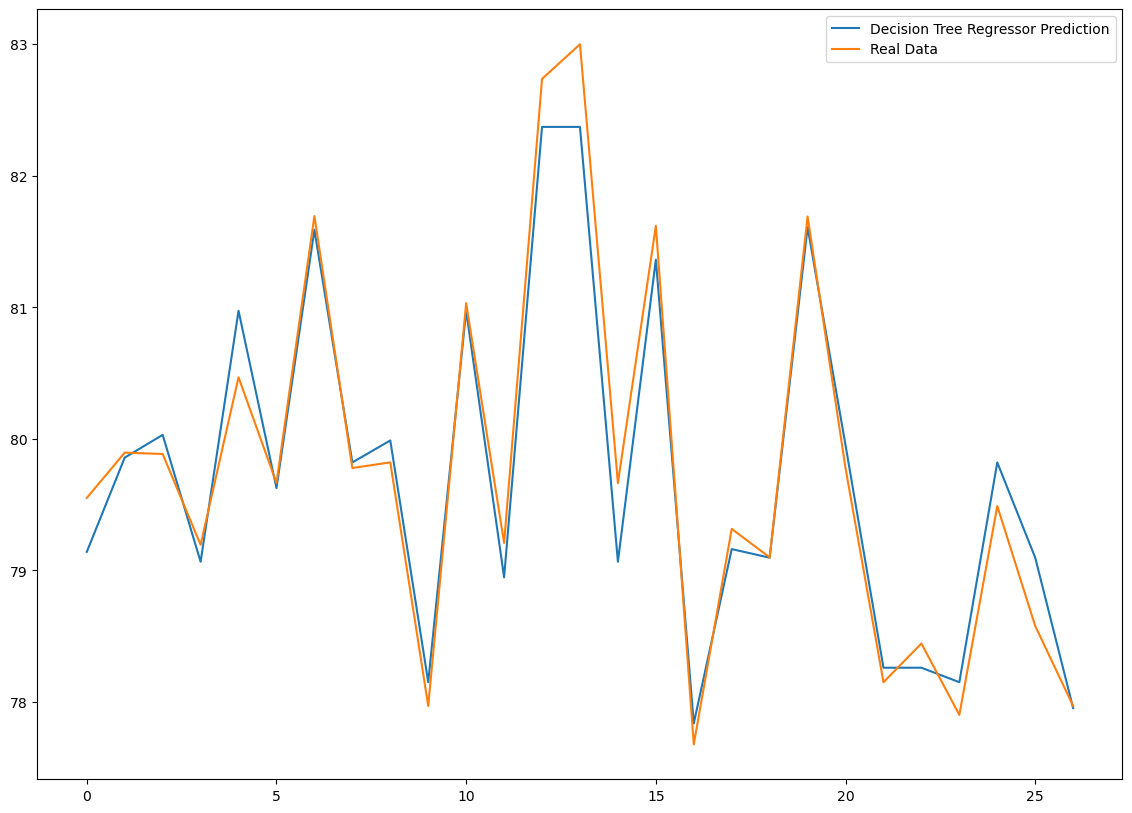

In [15]:
plt.figure(figsize=(14, 10))
plt.plot(dtr_y_pred, label = "Decision Tree Regressor Prediction")
plt.plot(ytest, label = "Real Data")
plt.legend()
plt.show()

### Applying Multilayer Perceptron (MLP)

In [16]:
mlp_model = MLPRegressor(activation='relu', max_iter = 4000, alpha = 100, hidden_layer_sizes=50, random_state=3, 
                   learning_rate_init=0.001, learning_rate='adaptive')

mlp_model.fit(xtrain, ytrain.flatten())
mlp_y_pred = mlp_model.predict(xtest)
print("Score of the MLP Model: ", mlp_model.score(xtest, ytest) * 100)

Score of the MLP Model:  95.37709237664261


#### Plotting prediction results with actual results

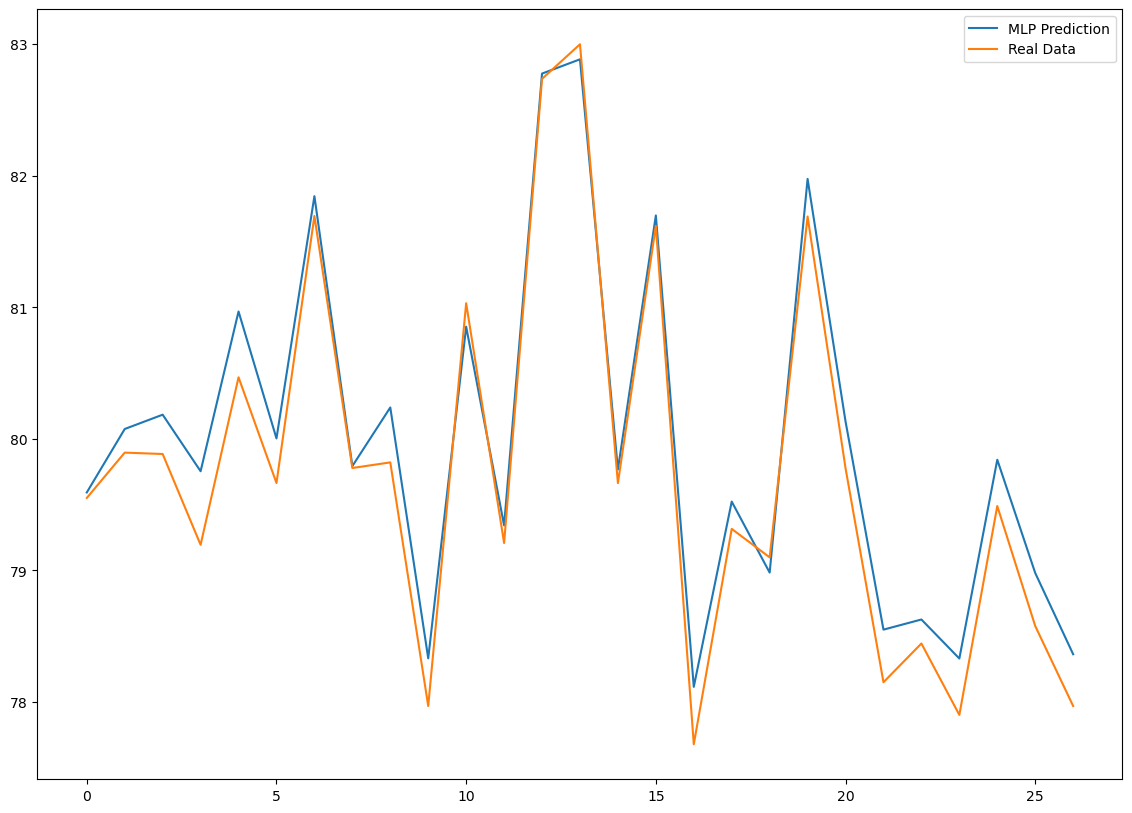

In [17]:
plt.figure(figsize=(14, 10))
plt.plot(mlp_y_pred, label = "MLP Prediction")
plt.plot(ytest, label = "Real Data")
plt.legend()
plt.show()

## Data evaluation

In [18]:
future = {
    'open' : 75.3,
    'high' : 76.2,
    'low' : 74.3
}

future_df = pd.DataFrame().append(future, ignore_index=True)
mlp_model.predict(future_df)

/var/folders/3p/jztlds7n24b0f5n7v8wsjt500000gn/T/ipykernel_12832/520286635.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  future_df = pd.DataFrame().append(future, ignore_index=True)
/Users/namitamhatre/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPRegressor was fitted without feature names
  warnings.warn(


array([75.58145013])

## Outcome/conclusion

In [20]:
currency_df.describe(include='O')

train_dataset = pd.DataFrame()
train_dataset['ds'] = pd.to_datetime(currency_df["date"])
train_dataset['y'] = y
train_dataset.head(2)

,ds,y
0,2022-06-01,77.57663
1,2022-06-02,77.38761


In [31]:
prophet_basic = Prophet()
prophet_basic.fit(train_dataset)

22:46:58 - cmdstanpy - INFO - Chain [1] start processing
22:46:58 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
future= prophet_basic.make_future_dataframe(periods=90)
future.head(2)

,ds
0,2022-06-01
1,2022-06-02


In [46]:
forecast = prophet_basic.predict(future)


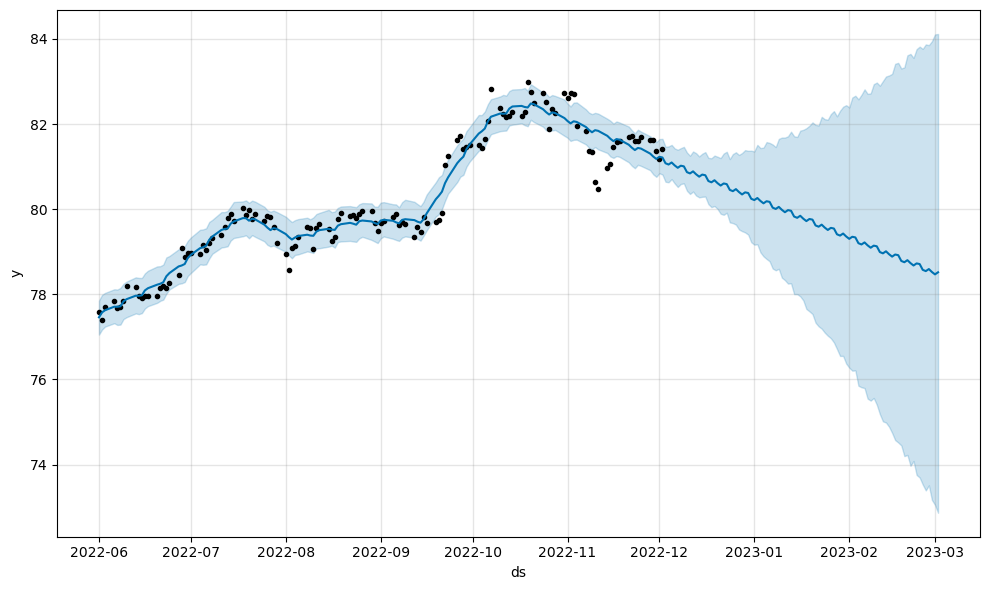

In [47]:
fig1 = prophet_basic.plot(forecast)


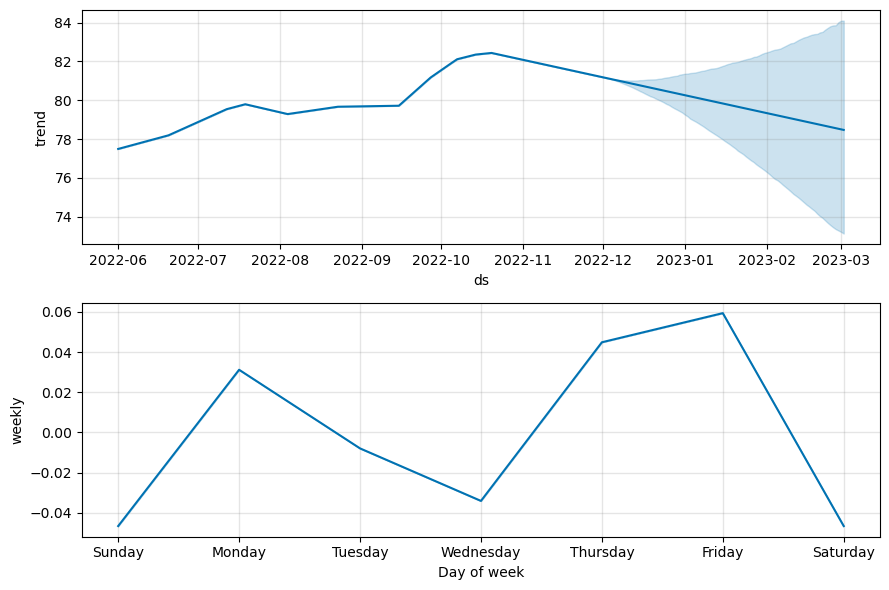

In [49]:
fig1 = prophet_basic.plot_components(forecast)


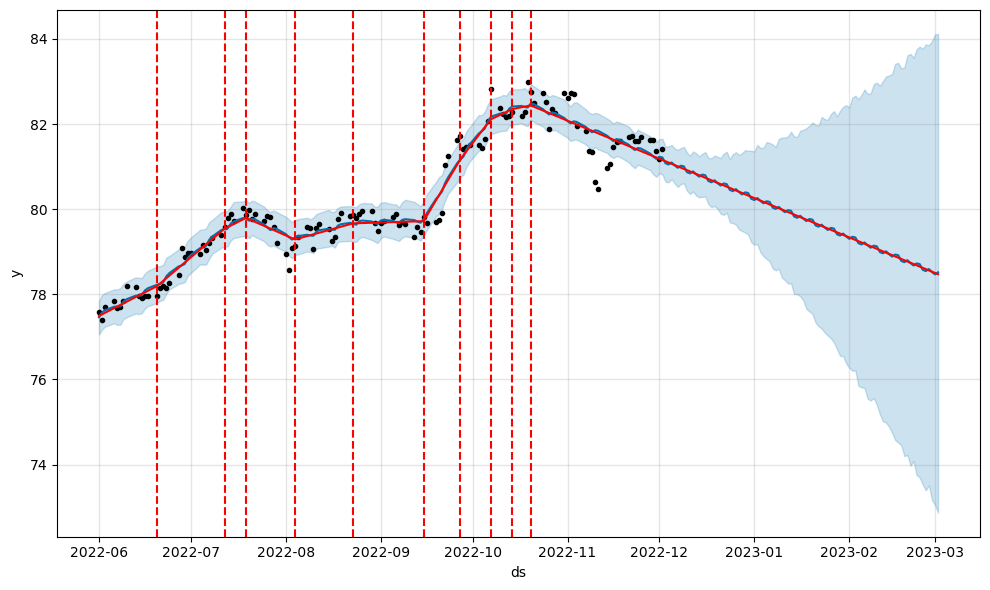

In [50]:
from prophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)


In [51]:
prophet_basic.changepoints

4     2022-06-07
8     2022-06-13
13    2022-06-20
17    2022-06-24
21    2022-06-30
25    2022-07-06
29    2022-07-12
34    2022-07-19
38    2022-07-25
42    2022-07-29
46    2022-08-04
50    2022-08-10
55    2022-08-17
59    2022-08-23
63    2022-08-29
67    2022-09-02
71    2022-09-08
76    2022-09-15
80    2022-09-21
84    2022-09-27
88    2022-10-03
92    2022-10-07
97    2022-10-14
101   2022-10-20
105   2022-10-26
Name: ds, dtype: datetime64[ns]

22:55:26 - cmdstanpy - INFO - Chain [1] start processing
22:55:27 - cmdstanpy - INFO - Chain [1] done processing


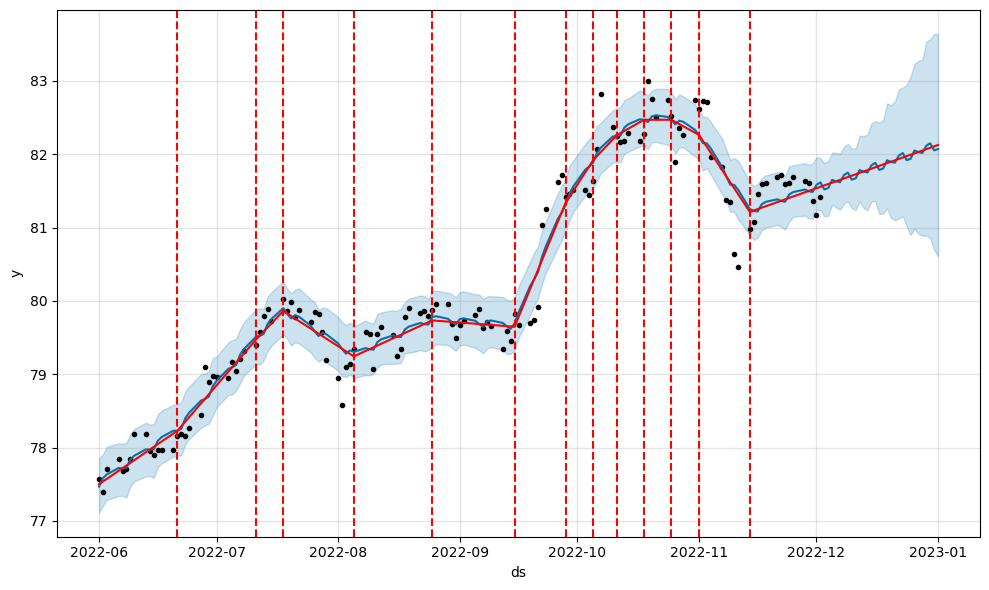

In [43]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(train_dataset).predict(future)
fig= pro_change.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)


In [54]:
#Additional Regressor
pro_regressor = Prophet()


#Fitting the data
pro_regressor.fit(xtrain)
future_data = pro_regressor.make_future_dataframe(periods=90)


#forecast the data for Test data
forecast_data = pro_regressor.predict(train_dataset)
pro_regressor.plot(forecast_data)


/Users/namitamhatre/opt/anaconda3/lib/python3.9/site-packages/prophet/forecaster.py:1109: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ('ds' not in df) or ('y' not in df):


ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.